## UnderStat is a website detailing results and stats from top tier football matches

Section 1 - Scraping understat for one link (to show how it's done step-by-step)

Section 2 - creating functions to iterate over multiple links, and scraping the whole site

The purpose of this notebook is to scrape Understat of all data related to final league positions and match statistics from the past 7 years for the top 5 leagues in world football

In [1]:
pip install selenium

Note: you may need to restart the kernel to use updated packages.


In [15]:
#packages used
import numpy as np
import pandas as pd 
import requests 
from bs4 import BeautifulSoup as bs 
import ast 
import json
from selenium import webdriver
import time
from PIL import Image
import matplotlib.pyplot as plot
from pprint import pprint
import html

## Section 1.1 - The 'simple scrape'

There are two methods we can use to get league positions. The first is to scrape the browser-shown data from each league as below


In [10]:
sys.path.append('/Users/jacoblourie')

In [7]:
import chromedriver_autoinstaller
chromedriver_autoinstaller.install()

'/Users/jacoblourie/miniconda3/lib/python3.9/site-packages/chromedriver_autoinstaller/90/chromedriver'

In [8]:
driver = webdriver.Chrome()
sample_url = "https://understat.com/league/EPL/2018"

driver.get(sample_url)
time.sleep(5)
#scrape the 'table'
table_outline = driver.find_element_by_xpath('//div[contains(@id, "league-chemp")]')
table = table_outline.find_element_by_tag_name('table')
print(table.text)


№ Team M W D L G GA PTS xG xGA xPTS
1 Manchester City 38 32 2 4 95 23 98 93.72-1.28 25.73+2.73 90.64-7.36
2 Liverpool 38 30 7 1 89 22 97 79.46-9.54 29.15+7.15 83.45-13.55
3 Chelsea 38 21 9 8 63 39 72 63.97+0.97 38.11-0.89 71.45-0.55
4 Tottenham 38 23 2 13 67 39 71 61.75-5.25 49.15+10.15 61.44-9.56
5 Arsenal 38 21 7 10 73 51 70 64.80-8.20 57.30+6.30 58.97-11.03
6 Manchester United 38 19 9 10 65 54 66 68.62+3.62 52.30-1.70 61.86-4.14
7 Wolverhampton Wanderers 38 16 9 13 47 46 57 53.06+6.06 42.69-3.31 59.91+2.91
8 Everton 38 15 9 14 54 46 54 53.87-0.13 49.31+3.31 55.54+1.54
9 Leicester 38 15 7 16 51 48 52 52.11+1.11 44.64-3.36 56.24+4.24
10 West Ham 38 15 7 16 52 55 52 47.96-4.04 65.66+10.66 43.72-8.28
11 Watford 38 14 8 16 52 59 50 51.73-0.27 63.29+4.29 46.00-4.00
12 Crystal Palace 38 14 7 17 51 53 49 50.64-0.36 52.80-0.20 51.93+2.93
13 Newcastle United 38 12 9 17 42 48 45 39.91-2.09 57.55+9.55 39.22-5.78
14 Bournemouth 38 13 6 19 56 70 45 58.81+2.81 62.42-7.58 51.49+6.49
15 Burnley 38 1

We could then split up each line (sep = '\n') and each stat (sep = ' ') and iterate across all the leagues.



## Section 1.2 Scraping UnderStat Using Scripts introduction

However, because we want to also get the individual match stats we will not use this method, instead looking at the data behind the site in scripts behind the network - response tab of 'inspect'

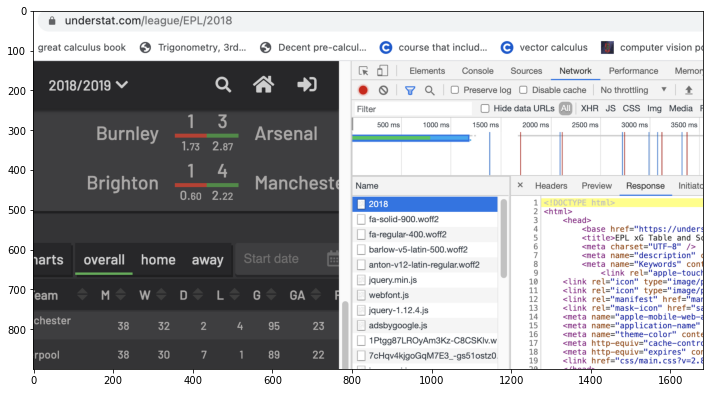

In [4]:
screenshot_of_network = '/Users/jacoblourie/Desktop/Understat_screenshot.png'
im = Image.open(screenshot_of_network)
fig = plot.figure(figsize = (12,8))
plot.imshow(im)
plot.show()

In those scripts, there are references to teamdata and player_data. We need the team data. Let's take a look at what one of the teams data sections looks like now

In [19]:
import lxml

In [21]:
#Initialise beautifulsoup package as we don't need to 'crawl' the site.
req = requests.get(sample_url)
html = req.content
soup = bs(html, 'html.parser')

#access the scripts
scripts = soup.find_all('script')

counter = 0 #to check how many teamsdata scripts there are
#look through all the 'scripts'
for script in scripts:

    #get the contents of all those scripts
    contents = script.contents
    for content in contents:

        #we're looking for to check we can find a 'teamsdata' one, and see what it looks like
        if 'teamsData' in content:
            teams_data = content
            print(f"Beginning of content looks like this: {teams_data[0:500]}") #print the first 500 characters 
            print(f"\nEnd of content looks like this: \n {teams_data[len(content)-100:]}") #print last 100 characters 
            counter +=1

print(f"\nthere are {counter} scripts with the word 'teamsdata' in them ")

print(f" the teams data is of data type: {type(teams_data)}")

Beginning of content looks like this: 
	var teamsData = JSON.parse('\x7B\x2272\x22\x3A\x7B\x22id\x22\x3A\x2272\x22,\x22title\x22\x3A\x22Everton\x22,\x22history\x22\x3A\x5B\x7B\x22h_a\x22\x3A\x22a\x22,\x22xG\x22\x3A0.7153819999999999623696567141450941562652587890625,\x22xGA\x22\x3A0.8910379999999999967030817060731351375579833984375,\x22npxG\x22\x3A0.7153819999999999623696567141450941562652587890625,\x22npxGA\x22\x3A0.8910379999999999967030817060731351375579833984375,\x22ppda\x22\x3A\x7B\x22att\x22\x3A312,\x22def\x22\x3A20\x7D,\x22ppd

End of content looks like this: 
 x3A0,\x22npxGD\x22\x3A\x2D0.8181089999999999751167933936812914907932281494140625\x7D\x5D\x7D\x7D');


there are 1 scripts with the word 'teamsdata' in them 
 the teams data is of data type: <class 'bs4.element.Script'>


## Turning this data into something usable

Great, so we have a teamsdata script, and it seems to be in a bs4.element.Script form

We can handle this by first encoding to utf8 & then decoding

In [30]:
type(teams_data)

bs4.element.Script

In [32]:
string_of_teams_data = teams_data.encode('utf8').decode('unicode_escape')
print(f"We now have data of type: {type(string_of_teams_data)}")
print(f"first 100 characters are: {string_of_teams_data[:100]}")
print(f"Last 100 characters are: {string_of_teams_data[len(string_of_teams_data)-100:]}")

We now have data of type: <class 'str'>
first 100 characters are: 
	var teamsData = JSON.parse('{"72":{"id":"72","title":"Everton","history":[{"h_a":"a","xG":0.715381
Last 100 characters are: ,"draws":0,"loses":1,"pts":0,"npxGD":-0.8181089999999999751167933936812914907932281494140625}]}}');



After repeating this with a few of the other URLs, the lengths are different but the format is the same. So first, let's get the bit which is actually a JSON from here:

In [33]:
start_index = string_of_teams_data.index("('") #this is the bit before the first '{'}
end_index = string_of_teams_data.index("\');\n") #this is the bit before the last '}'
json_data_cleaned = string_of_teams_data[start_index+2:end_index]
print(f"first 100 characters are: {json_data_cleaned[:100]}")
print(f"Last 100 characters are: {json_data_cleaned[len(string_of_teams_data)-100:]}")

first 100 characters are: {"72":{"id":"72","title":"Everton","history":[{"h_a":"a","xG":0.715381999999999962369656714145094156
Last 100 characters are: npxGD":-0.8181089999999999751167933936812914907932281494140625}]}}


In [34]:
dictionary_form_of_data = ast.literal_eval(json_data_cleaned)
print(dictionary_form_of_data.keys())
print('\n')
print(dictionary_form_of_data['72'])

dict_keys(['72', '73', '74', '75', '78', '80', '81', '82', '83', '86', '87', '88', '89', '90', '92', '219', '220', '227', '228', '229'])


{'id': '72', 'title': 'Everton', 'history': [{'h_a': 'a', 'xG': 0.715382, 'xGA': 0.891038, 'npxG': 0.715382, 'npxGA': 0.891038, 'ppda': {'att': 312, 'def': 20}, 'ppda_allowed': {'att': 228, 'def': 9}, 'deep': 2, 'deep_allowed': 4, 'scored': 2, 'missed': 2, 'xpts': 1.1703999999999999, 'result': 'd', 'date': '2018-08-11 19:30:00', 'wins': 0, 'draws': 1, 'loses': 0, 'pts': 1, 'npxGD': -0.17565600000000003}, {'h_a': 'h', 'xG': 2.02004, 'xGA': 1.77471, 'npxG': 2.02004, 'npxGA': 1.77471, 'ppda': {'att': 137, 'def': 27}, 'ppda_allowed': {'att': 216, 'def': 22}, 'deep': 4, 'deep_allowed': 7, 'scored': 2, 'missed': 1, 'xpts': 1.564, 'result': 'w', 'date': '2018-08-18 17:00:00', 'wins': 1, 'draws': 0, 'loses': 0, 'pts': 3, 'npxGD': 0.24532999999999983}, {'h_a': 'a', 'xG': 0.543665, 'xGA': 2.5887, 'npxG': 0.543665, 'npxGA': 1.82753, 'ppda': {'att': 208, 'def':

## So, we clearly have a dictionary of 20 keys (teams), and for each team, we have a ditionary which includes that teams 'History" - a list of all matches played in that season!

## Section 1.2 Turning this into a dataframe

First let's get a dictionary of teams and IDs 

NOTE: the JSON doesn't give the ID of the team they were playing, but we may be able to do a match later on to work out the 'match' to the other team's stats

In [35]:
teams = {}
for team in dictionary_form_of_data.keys():
    team_name = dictionary_form_of_data[team]['title']
    ID = dictionary_form_of_data[team]['id']
    teams[ID] = team_name

display(teams)

{'72': 'Everton',
 '73': 'Bournemouth',
 '74': 'Southampton',
 '75': 'Leicester',
 '78': 'Crystal Palace',
 '80': 'Chelsea',
 '81': 'West Ham',
 '82': 'Tottenham',
 '83': 'Arsenal',
 '86': 'Newcastle United',
 '87': 'Liverpool',
 '88': 'Manchester City',
 '89': 'Manchester United',
 '90': 'Watford',
 '92': 'Burnley',
 '219': 'Huddersfield',
 '220': 'Brighton',
 '227': 'Cardiff',
 '228': 'Fulham',
 '229': 'Wolverhampton Wanderers'}

Let's get the metrics in there in a dictionary too

In [36]:
#pick the first team ('72'), the 'history' sectionary, and the first [0] match
columns = dictionary_form_of_data['72']['history'][0].keys()
pprint(columns)        

dict_keys(['h_a', 'xG', 'xGA', 'npxG', 'npxGA', 'ppda', 'ppda_allowed', 'deep', 'deep_allowed', 'scored', 'missed', 'xpts', 'result', 'date', 'wins', 'draws', 'loses', 'pts', 'npxGD'])


In [37]:
#Now let's build a dictionary with all the dataframes in it, labelled by there ID.
all_teams = {}

#iterate through the teams in the dictionary of teams and IDs
for id, team in teams.items():

    #create blank list
    one_team = []
    for match in dictionary_form_of_data[id]['history']:
        
        #add a list of all the values in each match as a list to the bigger list of one_team
        one_team.append(match.values())

    #create a dataframe with the metrics as columns and the values of each match 
    df = pd.DataFrame(one_team, columns = columns)
    all_teams[team] = df

print(f"This is what each team looks like - first 5 matches only")
pprint(all_teams['Everton'].head(5))

This is what each team looks like - first 5 matches only
  h_a        xG       xGA      npxG     npxGA                     ppda  \
0   a  0.715382  0.891038  0.715382  0.891038  {'att': 312, 'def': 20}   
1   h  2.020040  1.774710  2.020040  1.774710  {'att': 137, 'def': 27}   
2   a  0.543665  2.588700  0.543665  1.827530  {'att': 208, 'def': 22}   
3   h  0.616013  0.660035  0.616013  0.660035  {'att': 179, 'def': 21}   
4   h  1.267740  1.524370  1.267740  1.524370  {'att': 179, 'def': 27}   

              ppda_allowed  deep  deep_allowed  scored  missed    xpts result  \
0   {'att': 228, 'def': 9}     2             4       2       2  1.1704      d   
1  {'att': 216, 'def': 22}     4             7       2       1  1.5640      w   
2  {'att': 187, 'def': 20}     4            11       2       2  0.1846      d   
3  {'att': 271, 'def': 29}     2             1       1       1  1.2222      d   
4  {'att': 244, 'def': 22}     5             7       1       3  1.1214      l   

           

Tidying up the PPDA data a little bit

In [38]:
for team, df in all_teams.items():
    #Basically, turning the dictionary into two columns
    all_teams[team]['ppda_coef'] = all_teams[team]['ppda'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)
    all_teams[team]['oppda_coef'] = all_teams[team]['ppda_allowed'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)
    del all_teams[team]['ppda']
    del all_teams[team]['ppda_allowed']

To get the full table, we need to sum up some columns, and take the mean of others

In [39]:


cols_to_sum = ['xG', 'xGA', 'npxG', 'npxGA', 'deep', 'deep_allowed', 'scored', 'missed', 'xpts', 'wins', 'draws', 'loses', 'pts', 'npxGD']
cols_to_mean = ['ppda_coef','oppda_coef']

In [40]:
frames = []
for team, df in all_teams.items():
    sumtables = pd.DataFrame(df[cols_to_sum].sum()).transpose()
    meantables = pd.DataFrame(df[cols_to_mean].mean()).transpose()
    oneteam = sumtables.join(meantables)
    oneteam['name'] = team
    oneteam['matches'] = len(df)
    frames.append(oneteam)

premtable = pd.concat(frames)   

In [41]:
premtable

,xG,xGA,npxG,npxGA,deep,deep_allowed,scored,missed,xpts,wins,draws,loses,pts,npxGD,ppda_coef,oppda_coef,name,matches
0,53.866134,49.309790,49.922344,45.396307,211.0,210.0,54.0,46.0,55.5378,15.0,9.0,14.0,54.0,4.526037,10.259641,10.972068,Everton,38
0,58.812899,62.423162,51.962379,58.617413,280.0,313.0,56.0,70.0,51.4947,13.0,6.0,19.0,45.0,-6.655034,17.275898,10.752281,Bournemouth,38
0,49.671325,59.271714,45.865480,56.988214,206.0,300.0,45.0,65.0,45.1075,9.0,12.0,17.0,39.0,-11.122734,12.041886,10.886729,Southampton,38
0,52.114153,44.642585,46.785979,40.836749,205.0,253.0,51.0,48.0,56.2378,15.0,7.0,16.0,52.0,5.949230,12.790205,11.480873,Leicester,38
0,50.642166,52.804285,42.269351,48.998432,256.0,261.0,51.0,53.0,51.9255,14.0,7.0,17.0,49.0,-6.729081,15.408263,9.201230,Crystal Palace,38
0,63.968004,38.107687,60.162158,36.447257,376.0,188.0,63.0,39.0,71.4510,21.0,9.0,8.0,72.0,23.714901,10.650183,15.995167,Chelsea,38
0,47.960528,65.662023,44.154837,61.856183,261.0,293.0,52.0,55.0,43.7194,15.0,7.0,16.0,52.0,-17.701346,13.315241,10.406223,West Ham,38
0,61.746657,49.146068,58.702020,45.340220,270.0,202.0,67.0,39.0,61.4400,23.0,2.0,13.0,71.0,13.361800,9.908482,17.680094,Tottenham,38
0,64.795372,57.297488,60.989521,51.969339,400.0,253.0,73.0,51.0,58.9713,21.0,7.0,10.0,70.0,9.020182,10.080325,13.944289,Arsenal,38
0,39.910651,57.545492,37.627142,52.978485,178.0,305.0,42.0,48.0,39.2231,12.0,9.0,17.0,45.0,-15.351344,14.721740,10.545338,Newcastle United,38


In [42]:
###just some sorting, renaming of columns, ordering
#Get them in a decent order
premtable_sorted = premtable[['name', 'matches', 'wins', 'draws', 'loses', 'scored', 'missed', 'pts', 'xG', 'npxG', 'xGA', 'npxGA', 'npxGD', 'ppda_coef', 'oppda_coef', 'deep', 'deep_allowed', 'xpts']]
premtable_sorted['GD'] = premtable_sorted['scored'] - premtable_sorted['missed']
#sort by 'pts'
premtable_sorted.sort_values(['pts','GD','scored'], ascending = [False,False,False], inplace = True)

#add 'positon'
premtable_sorted['position'] = range(1,len(premtable) +1)

#reset the index
premtable_sorted.set_index('position', inplace=True, drop = False)

#change the name of 'name' to 'team'
premtable_sorted.rename(columns = {'name':'Team', 'missed' : 'conceded'},inplace= True)

display(premtable_sorted)

<ipython-input-42-79b599d9defd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  premtable_sorted['GD'] = premtable_sorted['scored'] - premtable_sorted['missed']
<ipython-input-42-79b599d9defd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  premtable_sorted.sort_values(['pts','GD','scored'], ascending = [False,False,False], inplace = True)
<ipython-input-42-79b599d9defd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

,Team,matches,wins,draws,loses,scored,conceded,pts,xG,npxG,xGA,npxGA,npxGD,ppda_coef,oppda_coef,deep,deep_allowed,xpts,GD,position
position,,,,,,,,,,,,,,,,,,,,
1,Manchester City,38,32.0,2.0,4.0,95.0,23.0,98.0,93.720559,90.675880,25.732604,22.687925,67.987955,8.526164,30.468113,582.0,135.0,90.6406,72.0,1
2,Liverpool,38,30.0,7.0,1.0,89.0,22.0,97.0,79.457540,74.129360,29.145105,28.383936,45.745424,10.959871,22.161376,431.0,152.0,83.4541,67.0,2
3,Chelsea,38,21.0,9.0,8.0,63.0,39.0,72.0,63.968004,60.162158,38.107687,36.447257,23.714901,10.650183,15.995167,376.0,188.0,71.4510,24.0,3
4,Tottenham,38,23.0,2.0,13.0,67.0,39.0,71.0,61.746657,58.702020,49.146068,45.340220,13.361800,9.908482,17.680094,270.0,202.0,61.4400,28.0,4
5,Arsenal,38,21.0,7.0,10.0,73.0,51.0,70.0,64.795372,60.989521,57.297488,51.969339,9.020182,10.080325,13.944289,400.0,253.0,58.9713,22.0,5
6,Manchester United,38,19.0,9.0,10.0,65.0,54.0,66.0,68.617498,59.375862,52.300190,47.733182,11.642680,11.073851,14.433334,313.0,268.0,61.8596,11.0,6
7,Wolverhampton Wanderers,38,16.0,9.0,13.0,47.0,46.0,57.0,53.058692,50.014016,42.691294,39.646622,10.367394,15.863031,12.292938,184.0,220.0,59.9145,1.0,7
8,Everton,38,15.0,9.0,14.0,54.0,46.0,54.0,53.866134,49.922344,49.309790,45.396307,4.526037,10.259641,10.972068,211.0,210.0,55.5378,8.0,8
9,Leicester,38,15.0,7.0,16.0,51.0,48.0,52.0,52.114153,46.785979,44.642585,40.836749,5.949230,12.790205,11.480873,205.0,253.0,56.2378,3.0,9


## 1.3 Let's build a database of every single match in one table

In [16]:
all_matches_df = pd.DataFrame(columns = all_teams['Everton'].columns)
for team, matches_table in all_teams.items():
     temp_df = matches_table
     temp_df['Team'] = team
     all_matches_df = all_matches_df.append(temp_df)

all_matches_df = all_matches_df.reset_index().drop(columns = 'index')

OK, and let's find the matches between teams

In [17]:
dictionary_of_pair_name = {}
dictionary_of_pair_xpts = {}
for index, row in all_matches_df.iterrows():
    for index_2, row_2 in all_matches_df.iterrows():
        #let's match on two of the columns with very high level of decimal places, making a fake match nearly impossible
        if (row['xG'] == row_2['xGA']) and (row['npxG'] == row_2['npxGA']):
            dictionary_of_pair_name[index] = all_matches_df.iloc[index_2]['Team']
            dictionary_of_pair_xpts[index] = all_matches_df.iloc[index_2]['xpts']

#add those matched teams to the end of the table
all_matches_df['pair_index'] = dictionary_of_pair_name.values()
all_matches_df['xpts_other_team'] = dictionary_of_pair_xpts.values()
display(all_matches_df)

,h_a,xG,xGA,npxG,npxGA,deep,deep_allowed,scored,missed,xpts,...,wins,draws,loses,pts,npxGD,ppda_coef,oppda_coef,Team,pair_index,xpts_other_team
0,a,0.715382,0.891038,0.715382,0.891038,2,4,2,2,1.1704,...,0,1,0,1,-0.175656,15.600000,25.333333,Everton,Wolverhampton Wanderers,1.4521
1,h,2.020040,1.774710,2.020040,1.774710,4,7,2,1,1.5640,...,1,0,0,3,0.245330,5.074074,9.818182,Everton,Southampton,1.1668
2,a,0.543665,2.588700,0.543665,1.827530,4,11,2,2,0.1846,...,0,1,0,1,-1.283865,9.454545,9.350000,Everton,Bournemouth,2.7217
3,h,0.616013,0.660035,0.616013,0.660035,2,1,1,1,1.2222,...,0,1,0,1,-0.044022,8.523810,9.344828,Everton,Huddersfield,1.3716
4,h,1.267740,1.524370,1.267740,1.524370,5,7,1,3,1.1214,...,0,0,1,0,-0.256630,6.629630,11.090909,Everton,West Ham,1.5939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,h,2.604470,0.115051,2.604470,0.115051,7,0,0,0,2.8815,...,0,1,0,1,2.489419,27.166667,20.625000,Wolverhampton Wanderers,Brighton,0.0678
756,h,0.982018,0.939754,0.982018,0.939754,5,8,3,1,1.3400,...,1,0,0,3,0.042264,18.894737,13.181818,Wolverhampton Wanderers,Arsenal,1.3253
757,a,2.443570,0.896093,2.443570,0.896093,7,3,2,1,2.5372,...,1,0,0,3,1.547477,13.434783,11.529412,Wolverhampton Wanderers,Watford,0.3127
758,h,2.093970,0.512477,2.093970,0.512477,7,2,1,0,2.5504,...,1,0,0,3,1.581493,18.250000,8.363636,Wolverhampton Wanderers,Fulham,0.2953


,h_a,xG,xGA,npxG,npxGA,deep,deep_allowed,scored,missed,xpts,...,wins,draws,loses,pts,npxGD,ppda_coef,oppda_coef,Team,pair_index,xpts_other_team
0,a,0.715382,0.891038,0.715382,0.891038,2,4,2,2,1.1704,...,0,1,0,1,-0.175656,15.600000,25.333333,Everton,Wolverhampton Wanderers,1.4521
1,h,2.020040,1.774710,2.020040,1.774710,4,7,2,1,1.5640,...,1,0,0,3,0.245330,5.074074,9.818182,Everton,Southampton,1.1668
2,a,0.543665,2.588700,0.543665,1.827530,4,11,2,2,0.1846,...,0,1,0,1,-1.283865,9.454545,9.350000,Everton,Bournemouth,2.7217
3,h,0.616013,0.660035,0.616013,0.660035,2,1,1,1,1.2222,...,0,1,0,1,-0.044022,8.523810,9.344828,Everton,Huddersfield,1.3716
4,h,1.267740,1.524370,1.267740,1.524370,5,7,1,3,1.1214,...,0,0,1,0,-0.256630,6.629630,11.090909,Everton,West Ham,1.5939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,h,2.604470,0.115051,2.604470,0.115051,7,0,0,0,2.8815,...,0,1,0,1,2.489419,27.166667,20.625000,Wolverhampton Wanderers,Brighton,0.0678
756,h,0.982018,0.939754,0.982018,0.939754,5,8,3,1,1.3400,...,1,0,0,3,0.042264,18.894737,13.181818,Wolverhampton Wanderers,Arsenal,1.3253
757,a,2.443570,0.896093,2.443570,0.896093,7,3,2,1,2.5372,...,1,0,0,3,1.547477,13.434783,11.529412,Wolverhampton Wanderers,Watford,0.3127
758,h,2.093970,0.512477,2.093970,0.512477,7,2,1,0,2.5504,...,1,0,0,3,1.581493,18.250000,8.363636,Wolverhampton Wanderers,Fulham,0.2953


Each match is now in this table twice - e.g Everton v Wolves is in the table once in evertons' records and once in Wolves' records. Let's remove that by only taking the records wheere 'h_a' is 'h'

In [18]:
all_matches_dupes_removed = all_matches_df[all_matches_df['h_a'] == 'h']
all_matches_dupes_removed = all_matches_dupes_removed.rename(columns = {'xG' : 'xGH', 'npxG': 'npxGH', 'deep':'deepH', 'deep_allowed': 'deepa',
                                            'scored': 'home_scored', 'missed':'away_scored' , 'xpts' : 'xptsH', 'xpts_other_team':'xptsA',
                                            'ppda_coef' : 'ppdaH', 'oppda_coef' : 'pddaA'})
all_matches_dupes_removed = all_matches_dupes_removed.reset_index().drop(columns = ['h_a','index'])

In [19]:
all_matches_dupes_removed.columns

Index(['xGH', 'xGA', 'npxGH', 'npxGA', 'deepH', 'deepa', 'home_scored',
       'away_scored', 'xptsH', 'result', 'date', 'wins', 'draws', 'loses',
       'pts', 'npxGD', 'ppdaH', 'pddaA', 'Team', 'pair_index', 'xptsA'],
      dtype='object')

In [20]:
all_matches_dupes_removed

,xGH,xGA,npxGH,npxGA,deepH,deepa,home_scored,away_scored,xptsH,result,...,wins,draws,loses,pts,npxGD,ppdaH,pddaA,Team,pair_index,xptsA
0,2.020040,1.774710,2.020040,1.774710,4,7,2,1,1.5640,w,...,1,0,0,3,0.245330,5.074074,9.818182,Everton,Southampton,1.1668
1,0.616013,0.660035,0.616013,0.660035,2,1,1,1,1.2222,d,...,0,1,0,1,-0.044022,8.523810,9.344828,Everton,Huddersfield,1.3716
2,1.267740,1.524370,1.267740,1.524370,5,7,1,3,1.1214,l,...,0,0,1,0,-0.256630,6.629630,11.090909,Everton,West Ham,1.5939
3,2.315380,0.536317,1.554320,0.536317,7,6,3,0,2.6490,w,...,1,0,0,3,1.018003,8.307692,10.000000,Everton,Fulham,0.2253
4,1.927940,1.501740,1.927940,0.740567,10,5,2,0,1.6654,w,...,1,0,0,3,1.187373,8.800000,8.866667,Everton,Crystal Palace,1.0597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,3.207500,0.702261,3.207500,0.702261,7,3,2,0,2.8092,w,...,1,0,0,3,2.505239,8.866667,9.827586,Wolverhampton Wanderers,Cardiff,0.1236
376,1.650440,2.038470,1.650440,2.038470,5,7,2,1,1.0736,w,...,1,0,0,3,-0.388030,22.000000,11.730769,Wolverhampton Wanderers,Manchester United,1.6709
377,2.604470,0.115051,2.604470,0.115051,7,0,0,0,2.8815,d,...,0,1,0,1,2.489419,27.166667,20.625000,Wolverhampton Wanderers,Brighton,0.0678
378,0.982018,0.939754,0.982018,0.939754,5,8,3,1,1.3400,w,...,1,0,0,3,0.042264,18.894737,13.181818,Wolverhampton Wanderers,Arsenal,1.3253


## Section 1.4 Getting all the player data

In [21]:
#Start by itereating through the scripts again but getting the 'playersData'
for script in scripts:

    #get the contents of all those scripts
    contents = script.contents
    for content in contents:

        #we're looking for to check we can find a 'teamsdata' one, and see what it looks like
        if 'playersData' in content:
            playerdata = content
            print(f"Beginning of content looks like this: {playerdata[0:500]}") #print the first 500 characters 
            print(f"\nEnd of content looks like this: \n {playerdata[len(content)-100:]}") #print last 100 characters 
            counter +=1

print(f"\nthere are {counter} scripts with the word 'playersdata' in them ")

print(f" the player data is of data type: {type(playerdata)}")

Beginning of content looks like this: 
	var playersData	= JSON.parse('\x5B\x7B\x22id\x22\x3A\x22318\x22,\x22player_name\x22\x3A\x22Pierre\x2DEmerick\x20Aubameyang\x22,\x22games\x22\x3A\x2236\x22,\x22time\x22\x3A\x222740\x22,\x22goals\x22\x3A\x2222\x22,\x22xG\x22\x3A\x2223.549966726452112\x22,\x22assists\x22\x3A\x225\x22,\x22xA\x22\x3A\x224.989846890792251\x22,\x22shots\x22\x3A\x2294\x22,\x22key_passes\x22\x3A\x2233\x22,\x22yellow_cards\x22\x3A\x220\x22,\x22red_cards\x22\x3A\x220\x22,\x22position\x22\x3A\x22F\x20M\x20S\x22,\x22team_t

End of content looks like this: 
 GChain\x22\x3A\x220.9676404297351837\x22,\x22xGBuildup\x22\x3A\x220.9676404297351837\x22\x7D\x5D');


there are 2 scripts with the word 'playersdata' in them 
 the player data is of data type: <class 'bs4.element.Script'>


In [23]:
#Same decode as before
decoded_player_data = playerdata.encode('utf8').decode('unicode_escape')

#Same as before, create the indexes to do the slice on
start_index_players = decoded_player_data.index("('") #this is the bit before the first '{'}
end_index_players = decoded_player_data.index("\');\n") #this is the bit before the last '}'
player_data_cleaned = decoded_player_data[start_index_players+3:end_index_players-1]

#Data comes as a tupe this time
player_data_tuple = ast.literal_eval(player_data_cleaned)

#And happily, we can easily convert this to a dataframe with one command.
player_data_df = pd.DataFrame(player_data_tuple)

In [26]:
pprint(player_data_df.head(5).T)

                                      0                   1  \
id                                  318                 838   
player_name   Pierre-Emerick Aubameyang          Sadio Mané   
games                                36                  36   
time                               2740                3100   
goals                                22                  22   
xG                   23.549966726452112  16.762808084487915   
assists                               5                   1   
xA                    4.989846890792251   5.123734523542225   
shots                                94                  87   
key_passes                           33                  45   
yellow_cards                          0                   2   
red_cards                             0                   0   
position                          F M S               F M S   
team_title                      Arsenal           Liverpool   
npg                                  18                

## Section 2 - creating loops to scrape all leagues

Section 2.1 - Doing the base work to scrape the site

In [2]:
# Let's store the data in three dictionaries.
dict_leagues = {}
dict_matches = {}
dict_player_stats = {}

#Let's store the base url and the 'endings'
base_url = "https://understat.com/league/"
leagues = ['EPL','La_liga','Bundesliga','Serie A','Ligue 1']
years = ['2020','2015','2016','2017','2018','2019','2014']

# We'll do the full run for each league separately
#Initialise beautifulsoup package as we don't need to 'crawl' the site.
def get_teams_data(url):
    req = requests.get(url)
    html = req.content
    soup = bs(html, 'lxml')

    teams_data = ''
    #access the scripts
    scripts = soup.find_all('script')

    counter = 0 #to check how many teamsdata scripts there are
    #look through all the 'scripts'
    for script in scripts:

        #get the contents of all those scripts
        contents = script.contents
        for content in contents:

            #we're looking for to check we can find a 'teamsdata' one, and see what it looks like
            if 'teamsData' in content:
                teams_data = content
                
    return teams_data

#test_func_form_step_1 = get_teams_data(base_url + leagues[0] + '/' + years[0])

In [29]:
#Then turn that byte_form data into a dictionary
def script_to_dict(teams_data):
    string_of_teams_data = teams_data.encode('utf8').decode('unicode_escape')
    start_index = string_of_teams_data.index("('") #this is the bit before the first '{'}
    end_index = string_of_teams_data.index("\');\n") #this is the bit before the last '}'
    json_data_cleaned = string_of_teams_data[start_index+2:end_index]
    dictionary_form_of_data = ast.literal_eval(json_data_cleaned)
    return dictionary_form_of_data

test_func_form_step_2 = script_to_dict(test_func_form_step_1)

In [31]:
#then turn into a dataframe of matches
def dict_of_matches_to_df_form(dictionary_form_of_data):
    teams = {}
    #get all the team_names
    for team in dictionary_form_of_data.keys():
        team_name = dictionary_form_of_data[team]['title']
        ID = dictionary_form_of_data[team]['id']
        teams[ID] = team_name

    #get the metrics
    season_metrics = columns ###THIS TAKES FROM SECTION 1 

    #Now let's build a dictionary with all the dataframes in it, labelled by there ID.
    all_teams = {}

    #iterate through the teams in the dictionary of teams and IDs
    for id, team in teams.items():
        #create blank list
        one_team = []
        for match in dictionary_form_of_data[id]['history']:
            
            #add a list of all the values in each match as a list to the bigger list of one_team
            one_team.append(match.values())

        #create a dataframe with the metrics as columns and the values of each match 
        df = pd.DataFrame(one_team, columns = columns)
        all_teams[team] = df
    
    return all_teams

test_func_form_df_of_all_matches = dict_of_matches_to_df_form(test_func_form_step_2)

In [33]:
def clean_tables_ppda(dict_of_many_teams_matches):
    #Basically, turning the dictionary column of ppda into two columns
    for team, df in dict_of_many_teams_matches.items():
        dict_of_many_teams_matches[team]['ppda_coef'] = dict_of_many_teams_matches[team]['ppda'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)
        dict_of_many_teams_matches[team]['oppda_coef'] = dict_of_many_teams_matches[team]['ppda_allowed'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)
        del dict_of_many_teams_matches[team]['ppda']
        del dict_of_many_teams_matches[team]['ppda_allowed']
    
    return dict_of_many_teams_matches
test_func_form_cleaned = clean_tables_ppda(test_func_form_df_of_all_matches)

2.2 Then creating the big table of a single league

In [35]:


def turn_matches_to_league_table(dict_of_many_teams_matches):
    frames = []
    for team, df in dict_of_many_teams_matches.items():
        
        cols_to_sum = ['xG', 'xGA', 'npxG', 'npxGA', 'deep', 'deep_allowed', 'scored', 'missed', 'xpts', 'wins', 'draws', 'loses', 'pts', 'npxGD']
        cols_to_mean = ['ppda_coef','oppda_coef']
        sumtables = pd.DataFrame(df[cols_to_sum].sum()).transpose()
        meantables = pd.DataFrame(df[cols_to_mean].mean()).transpose()
        oneteam = sumtables.join(meantables)
        oneteam['name'] = team
        oneteam['matches'] = len(df)
        frames.append(oneteam)

    league_table = pd.concat(frames)   
    ###just some sorting, renaming of columns, ordering
    #Get them in a decent order
    league_table_sorted = league_table[['name', 'matches', 'wins', 'draws', 'loses', 'scored', 'missed', 'pts', 'xG', 'npxG', 'xGA', 'npxGA', 'npxGD', 'ppda_coef', 'oppda_coef', 'deep', 'deep_allowed', 'xpts']]
    league_table_sorted['GD'] = league_table_sorted['scored'] - league_table_sorted['missed']
    #sort by 'pts'
    league_table_sorted.sort_values(['pts','GD','scored'], ascending = [False,False,False], inplace = True)

    #add 'positon'
    league_table_sorted['position'] = range(1,len(league_table_sorted) +1)

    #reset the index
    league_table_sorted.set_index('position', inplace=True, drop = False)

    #change the name of 'name' to 'team'
    league_table_sorted.rename(columns = {'name':'Team', 'missed' : 'conceded'},inplace= True)
        
    return league_table_sorted

test_func_form_leauge_table = turn_matches_to_league_table(test_func_form_cleaned)

<ipython-input-35-9844f3b57fec>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  league_table_sorted['GD'] = league_table_sorted['scored'] - league_table_sorted['missed']
<ipython-input-35-9844f3b57fec>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  league_table_sorted.sort_values(['pts','GD','scored'], ascending = [False,False,False], inplace = True)
<ipython-input-35-9844f3b57fec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

2.3 Then the functions to create the big matches table

In [36]:
#Now create functions that will help create the big database of matches, before running the iteration
def create_big_table_of_matches(dict_of_all_teams_matches):
    #create empty database
    keys_in_dict = list(dict_of_all_teams_matches.keys())
    all_matches_df = pd.DataFrame(columns = dict_of_all_teams_matches[keys_in_dict[0]].columns)
    for team, matches_table in dict_of_all_teams_matches.items():
        temp_df = matches_table
        temp_df['Team'] = team
        all_matches_df = all_matches_df.append(temp_df)

    all_matches_df = all_matches_df.reset_index().drop(columns = 'index')
    return all_matches_df

test_func_one_season_matches_table = create_big_table_of_matches(test_func_form_df_of_all_matches)

In [37]:
#Now add the 'Pairs'
def add_pairs(all_matches_df):
    
    dictionary_of_pair_name = {}
    dictionary_of_pair_xpts = {}
    for index, row in all_matches_df.iterrows():
        if index not in dictionary_of_pair_name.keys(): #so don't go around again if you've already found that pair
            for index_2, row_2 in all_matches_df.iterrows():
                #let's match on two of the columns with very high level of decimal places, making a fake match nearly impossible
                if (row['xG'] == row_2['xGA']) and (row['npxG'] == row_2['npxGA']):
                    dictionary_of_pair_name[index] = all_matches_df.iloc[index_2]['Team']
                    dictionary_of_pair_xpts[index] = all_matches_df.iloc[index_2]['xpts']
                    dictionary_of_pair_name[index_2] = all_matches_df.iloc[index]['Team']
                    dictionary_of_pair_xpts[index_2] = all_matches_df.iloc[index]['xpts']

    #add those matched teams to the end of the table
    all_matches_df['pair_index'] = dictionary_of_pair_name.values()
    all_matches_df['xpts_other_team'] = dictionary_of_pair_xpts.values()
    return all_matches_df

test_func_paired_matches = add_pairs(test_func_one_season_matches_table)

In [39]:
#Nowe remove duplicates and rename the columns so it's in the fomr of one team versus the other (and home and away stats)
def final_presentation_matches_table(all_matches_df):
    all_matches_dupes_removed = all_matches_df[all_matches_df['h_a'] == 'h']
    all_matches_dupes_removed = all_matches_dupes_removed.rename(columns = {'xG' : 'xGH', 'npxG': 'npxGH', 'deep':'deepH', 'deep_allowed': 'deepa',
                                                'scored': 'home_scored', 'missed':'away_scored' , 'xpts' : 'xptsH', 'xpts_other_team':'xptsA',
                                                'ppda_coef' : 'ppdaH', 'oppda_coef' : 'pddaA','Team':'Home Team','pair_index':'Away Team'})
    all_matches_dupes_removed = all_matches_dupes_removed.reset_index().drop(columns = ['h_a','index'])
    return all_matches_dupes_removed

test_func_final_matches_layout = final_presentation_matches_table(test_func_paired_matches)

2.4 - Doing the loop and creating the csv files

In [41]:
##Let's try iterating and creating the first dictionary needed. Here are the iterators and dictionaries we s tored earlier 
'''dict_leagues = {}
dict_matches = {}
dict_player_stats = {}

#Let's store the base url and the 'endings'
base_url = "https://understat.com/league/"
leagues = ['EPL','La_liga','Bundesliga','Serie A','Ligue 1']
years = ['2020','2015','2016','2017','2018','2019','2014']'''
dict_leagues = {}
dict_matches = {}
import time
time_now = time.time()
for league in leagues:
    for year in years:
        print(league,year)
        print(time.time() - time_now)
         #create base layer
        raw_data = get_teams_data(base_url+league+'/'+year)
        dict_form_data = script_to_dict(raw_data)
        df_form_data = dict_of_matches_to_df_form(dict_form_data)
        clean_ppda = clean_tables_ppda(df_form_data)
        
         #now sort the league data out
        league_table = turn_matches_to_league_table(clean_ppda)
        league_table['league'] = league #add league name to table
        league_table['year'] = year #add league year to table
        dict_leagues[f'{league}_{year}'] = league_table #add to dictionary
        
        #now sort the match data out
        table_of_all_matches = create_big_table_of_matches(clean_ppda)
        paired_matches = add_pairs(table_of_all_matches)
        matches_table_one_season = final_presentation_matches_table(paired_matches)
        matches_table_one_season['league'] = league 
        matches_table_one_season['year'] = year
        dict_matches[f'{league}_{year}'] = matches_table_one_season

       

EPL 2020
0.000743865966796875
<ipython-input-35-9844f3b57fec>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  league_table_sorted['GD'] = league_table_sorted['scored'] - league_table_sorted['missed']
<ipython-input-35-9844f3b57fec>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  league_table_sorted.sort_values(['pts','GD','scored'], ascending = [False,False,False], inplace = True)
<ipython-input-35-9844f3b57fec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [42]:
#iterating through and saving to a dictionary
for keys, values in dict_matches.items():
    filename = f'Project_data/match_tables/{keys}'
    values.to_csv(filename)

for keys, values in dict_leagues.items():
    filename = f'Project_data/league_tables/{keys}'
    values.to_csv(filename)

Section 2.5 - Creating the players data

In [5]:
def get_player_data(url):
    req = requests.get(url)
    html = req.content
    soup = bs(html, 'lxml')

    #access the scripts
    scripts = soup.find_all('script')



    #Start by itereating through the scripts again but getting the 'playersData'
    for script in scripts:

        #get the contents of all those scripts
        contents = script.contents
        for content in contents:

            #we're looking for to check we can find a 'teamsdata' one, and see what it looks like
            if 'playersData' in content:
                playerdata = content
                
    return playerdata
test_func_player_data_1 = get_player_data(base_url + leagues[0] + '/' + years[0])

In [9]:

def decode_and_data_frame_player_data(playerdata):
    #Same decode as before
    decoded_player_data = playerdata.encode('utf8').decode('unicode_escape')

    #Same as before, create the indexes to do the slice on
    start_index_players = decoded_player_data.index("('") #this is the bit before the first '{'}
    end_index_players = decoded_player_data.index("\');\n") #this is the bit before the last '}'
    player_data_cleaned = decoded_player_data[start_index_players+3:end_index_players-1]

    #Data comes as a tupe this time
    player_data_tuple = ast.literal_eval(player_data_cleaned)

    #And happily, we can easily convert this to a dataframe with one command.
    player_data_df = pd.DataFrame(player_data_tuple)
    return player_data_df
test_df_player_data = decode_and_data_frame_player_data(test_func_player_data_1)

In [12]:
#Run the loop!
dict_player_stats = {}
for league in leagues:
    for year in years:
        player_data = get_player_data(base_url + league + '/' + year)
        player_data_df = decode_and_data_frame_player_data(player_data)
        dict_player_stats[f'{league}_{year}'] = player_data_df

In [17]:
for keys, values in dict_player_stats.items():
    filename = f'Project_data/player_stats/{keys}'
    values.to_csv(filename)